In [1]:
import pandas as pd

# Load dataset
df = pd.read_csv(r"D:\ML PROJECTS\Netflix Content Analysis and Recommendation System\netflix_titles.csv")

# Show basic info
print("📝 Dataset shape:", df.shape)
print("\n🧾 Columns:", df.columns.tolist())
print("\n📊 Sample rows:")
print(df.head())


📝 Dataset shape: (8807, 12)

🧾 Columns: ['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added', 'release_year', 'rating', 'duration', 'listed_in', 'description']

📊 Sample rows:
  show_id     type                  title         director  \
0      s1    Movie   Dick Johnson Is Dead  Kirsten Johnson   
1      s2  TV Show          Blood & Water              NaN   
2      s3  TV Show              Ganglands  Julien Leclercq   
3      s4  TV Show  Jailbirds New Orleans              NaN   
4      s5  TV Show           Kota Factory              NaN   

                                                cast        country  \
0                                                NaN  United States   
1  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   South Africa   
2  Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...            NaN   
3                                                NaN            NaN   
4  Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...          India   

    

In [3]:
# Drop duplicates and handle missing values
df.drop_duplicates(inplace=True)
df.dropna(subset=['title', 'type', 'listed_in', 'description'], inplace=True)

# Convert 'date_added' to datetime
df['date_added'] = pd.to_datetime(df['date_added'].str.strip(), errors='coerce')


# Fill missing values with 'Unknown'
df['director'].fillna('Unknown', inplace=True)
df['cast'].fillna('Unknown', inplace=True)
df['country'].fillna('Unknown', inplace=True)
df['rating'].fillna('Unknown', inplace=True)

# Extract year and month for analysis
df['year_added'] = df['date_added'].dt.year
df['month_added'] = df['date_added'].dt.month


C:\Users\yuvan\AppData\Local\Temp\ipykernel_12368\1783851085.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['director'].fillna('Unknown', inplace=True)
C:\Users\yuvan\AppData\Local\Temp\ipykernel_12368\1783851085.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exa

C:\Users\yuvan\AppData\Local\Temp\ipykernel_12368\3358767736.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="type", palette="Set2")


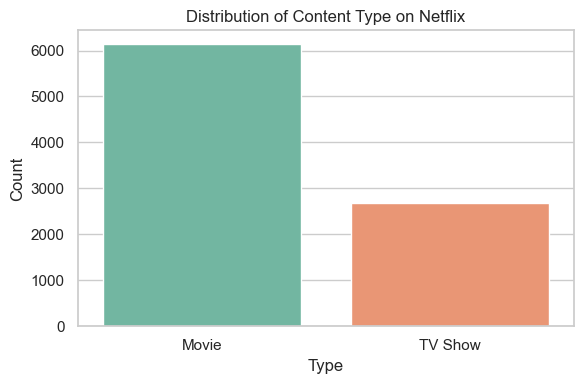

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="type", palette="Set2")
plt.title("Distribution of Content Type on Netflix")
plt.xlabel("Type")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


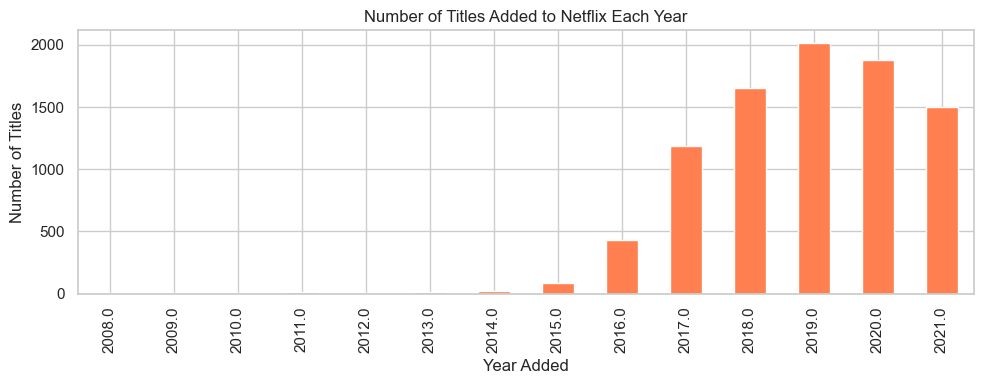

In [5]:
plt.figure(figsize=(10, 4))
df['year_added'].value_counts().sort_index().plot(kind='bar', color='coral')
plt.title("Number of Titles Added to Netflix Each Year")
plt.xlabel("Year Added")
plt.ylabel("Number of Titles")
plt.tight_layout()
plt.show()


C:\Users\yuvan\AppData\Local\Temp\ipykernel_12368\368965667.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_countries.values, y=top_countries.index, palette='coolwarm')


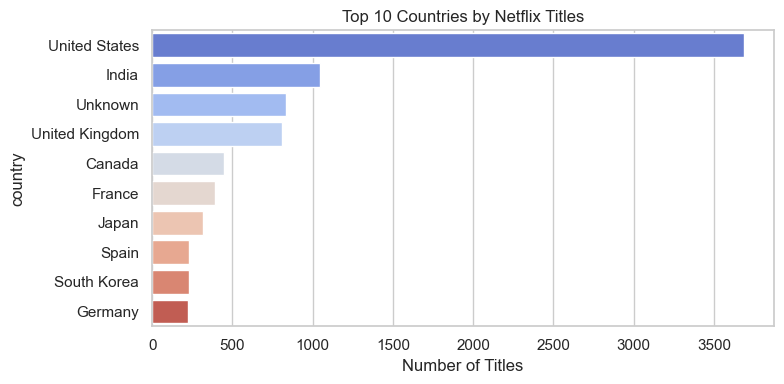

In [6]:
from collections import Counter

# Split multiple countries per title
country_series = df['country'].dropna().str.split(',').explode().str.strip()
top_countries = country_series.value_counts().head(10)

plt.figure(figsize=(8, 4))
sns.barplot(x=top_countries.values, y=top_countries.index, palette='coolwarm')
plt.title("Top 10 Countries by Netflix Titles")
plt.xlabel("Number of Titles")
plt.tight_layout()
plt.show()


C:\Users\yuvan\AppData\Local\Temp\ipykernel_12368\3530494664.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_genres.values, y=top_genres.index, palette='viridis')


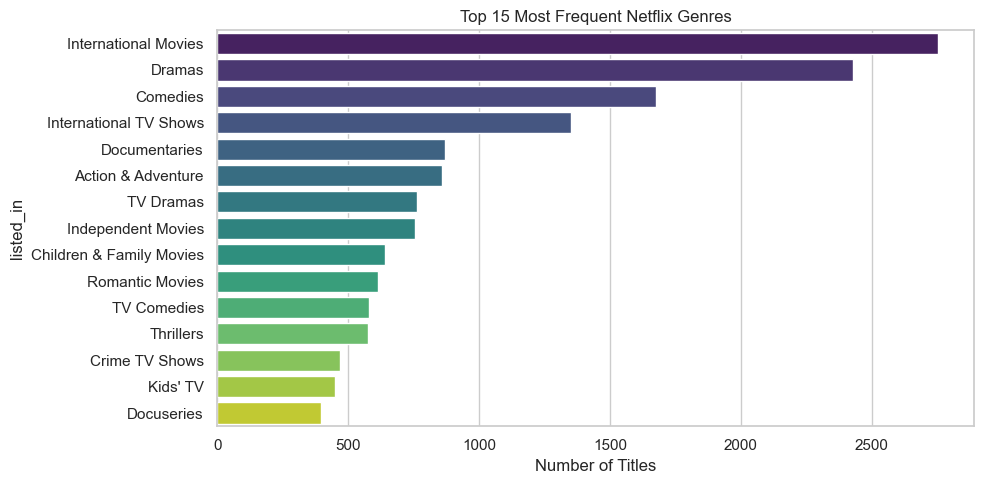

In [7]:
genre_series = df['listed_in'].str.split(',').explode().str.strip()
top_genres = genre_series.value_counts().head(15)

plt.figure(figsize=(10, 5))
sns.barplot(x=top_genres.values, y=top_genres.index, palette='viridis')
plt.title("Top 15 Most Frequent Netflix Genres")
plt.xlabel("Number of Titles")
plt.tight_layout()
plt.show()


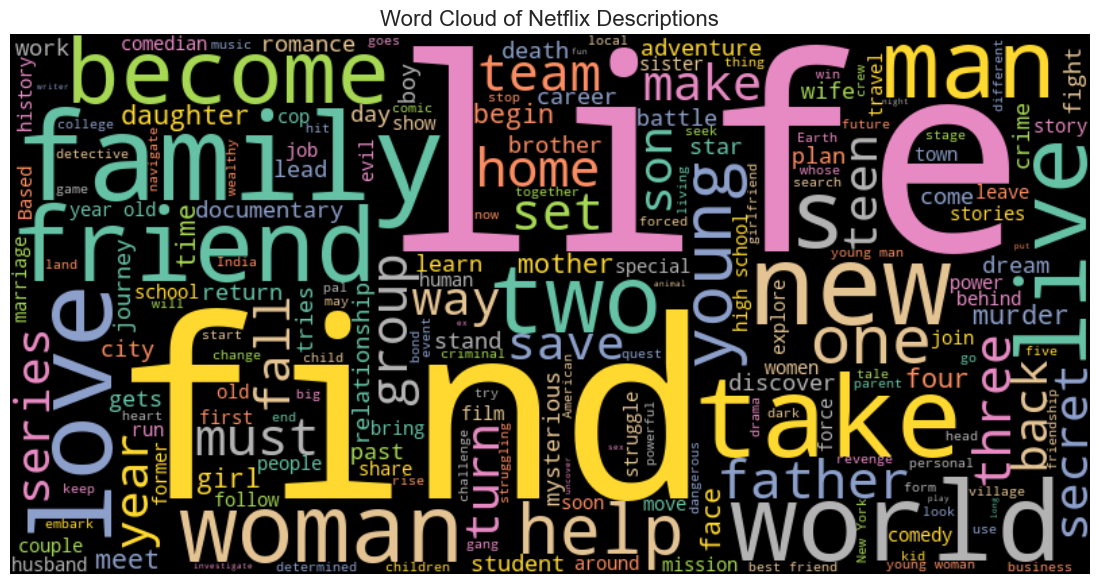

In [8]:
from wordcloud import WordCloud

text = ' '.join(df['description'].dropna().tolist())
wc = WordCloud(width=800, height=400, background_color='black', colormap='Set2').generate(text)

plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Netflix Descriptions", fontsize=16)
plt.tight_layout()
plt.show()


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pickle

# Reset index for mapping indices back to titles
df = df.reset_index(drop=True)

# TF-IDF Vectorization on 'description'
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['description'])

# Compute cosine similarity matrix
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Create a Series mapping titles to indices
title_to_index = pd.Series(df.index, index=df['title']).drop_duplicates()

# 🎯 Recommendation function
def get_recommendations(title, cosine_sim=cosine_sim):
    if title not in title_to_index:
        return ["❌ Title not found in dataset."]
    
    idx = title_to_index[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:6]  # Top 5 excluding self
    movie_indices = [i[0] for i in sim_scores]
    return df['title'].iloc[movie_indices].tolist()

# ✅ Test
print("🎬 Recommendations for 'Breaking Bad':")
print(get_recommendations('Breaking Bad'))


🎬 Recommendations for 'Breaking Bad':
['The Book of Sun', 'Alice Junior', 'Iron Ladies', 'Dismissed', 'Alexa & Katie']


In [12]:
import os

save_dir = "D:/ML PROJECTS/Netflix Content Analysis and Recommendation System/"
os.makedirs(save_dir, exist_ok=True)

pickle.dump(tfidf, open(os.path.join(save_dir, "tfidf_vectorizer.pkl"), "wb"))
pickle.dump(cosine_sim, open(os.path.join(save_dir, "cosine_sim_matrix.pkl"), "wb"))
pickle.dump(df[['title']], open(os.path.join(save_dir, "netflix_titles.pkl"), "wb"))

